# Tutorial 3: Non-Interactive Workflow

This notebook focuses on a **non-interactive workflow** for 1D wavelength calibration that is
particularly useful for **automated data reduction pipelines** where the instrument configuration
(spectrograph, grating/grism, approximate wavelength range) is well-characterized beforehand.

Instead of requiring manual identification of initial line pairs (as shown in Tutorials 1 and 2
using `WavelengthCalibration1D.fit_lines`), this workflow uses the
`WavelengthCalibration1D.fit_global` method. This method uses a global optimization algorithm to
determine the wavelength solution. It achieves this by automatically finding the best polynomial
coefficients that minimize the overall distance between detected arc lamp lines and a provided
catalog of theoretical line wavelengths.

During the optimization, the algorithm uses a KD-tree data structure to efficiently find
the nearest catalog lines to each detected line. This approach speeds up the distance
calculations needed in each iteration of the optimization, making it practical to
search through large parameter spaces with many detected and catalog lines.

A key requirement for `fit_global` is providing reasonable initial **bounds** for the wavelength
and dispersion (Å/pixel) at a chosen reference pixel. These bounds are derived from **prior
knowledge** of the instrument setup and guide the optimization search.

Like Tutorial 2, this example uses three arc lamp spectra (HgAr, Ne, Xe) obtained with the R1000R
grism of the [Osiris spectrograph](https://www.gtc.iac.es/instruments/osiris/) at the
[Gran Telescopio Canarias (GTC)](https://www.gtc.iac.es/).


In [1]:
import astropy.units as u
import numpy as np

from astropy.table import Table
from astropy.nddata import StdDevUncertainty
from matplotlib.pyplot import setp, subplots, close, rc

from specreduce.compat import Spectrum
from specreduce.wavecal1d import WavelengthCalibration1D

rc('figure', figsize=(6.3, 2))

## 1. Initialize the Wavelength Calibration Class

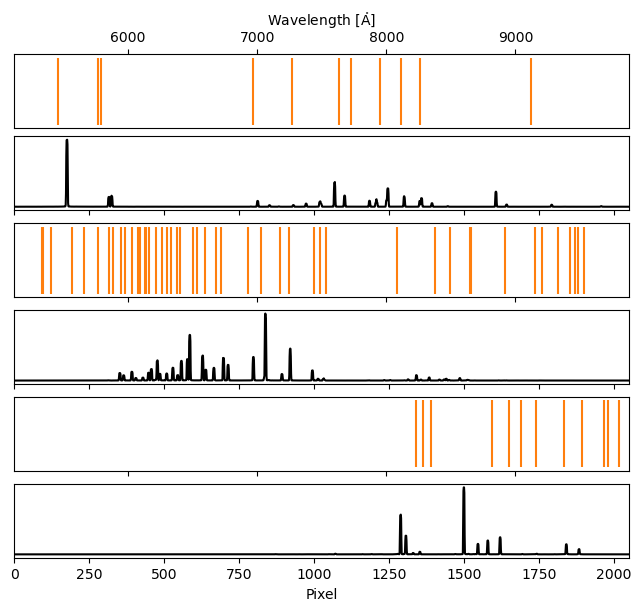

In [2]:
lamps = 'HgAr', 'Ne', 'Xe'
hgar_lines = np.array([5460.735, 5769.598, 5790.663,  6965.431, 7272.936, 7635.106,
                     7724.207, 7948.176, 8115.311, 8264.522, 9122.967])

tb = Table.read('osiris_arcs.fits')
arc_spectra = [Spectrum(flux=tb[f'{l}_flux'].value.astype('d')*u.DN,
                         uncertainty=StdDevUncertainty(tb[f'{l}_err'].value.astype('d')))
                 for l in lamps]

wc = WavelengthCalibration1D(ref_pixel=1000,
                             degree=4,
                             arc_spectra=arc_spectra,
                             line_lists=[hgar_lines, ['NeI'], ['XeI']],
                             line_list_bounds=(5100, 9900),
                             unit=u.angstrom,
                             wave_air=True)

wc.plot_fit(figsize=(6.3, 6), plot_values=False);

## 2. Perform Automated Fit using `fit_global`

With the `WavelengthCalibration1D` object initialized, we proceed to calculate the wavelength solution automatically.

**Step 1: Find Lines**
We first execute `ws.find_lines()`. This step automatically detects emission lines in each of the input arc spectra (`arc_spectra`) and calculates their pixel centroids. These detected centroids are stored internally in `ws.observed_lines`. The `fwhm` (estimated line width in pixels) and `noise_factor` parameters help the algorithm distinguish real lines from noise; these may need tuning depending on the data quality.

**Step 2: Global Fit**
Next, the core of the non-interactive workflow: `ws.fit_global()`. This method initiates the global optimization search.
- **No Manual Input:** Notice we do *not* provide any specific pixel-wavelength pairs.
- **Bounds are Key:** Instead, we *must* provide `wavelength_bounds` and `dispersion_bounds`. These constrain the optimizer's search space for the polynomial coefficients. They represent our *a priori* knowledge about the instrument setup.
  - For this GTC/OSIRIS R1000R example, we know the approximate central wavelength is ~7430 Å and the dispersion near the center is ~2.62 Å/pixel. We provide bounds around these values: `wavelength_bounds=[7420, 7470]` Å and `dispersion_bounds=[2.5, 2.7]` Å/pixel.
- **Optimization Process:** The differential evolution algorithm searches for polynomial
coefficients within these constraints (and narrower limits for higher-order terms) that best map
the detected `observed_lines` to the `catalog_lines` by minimizing the sum of distances to the nearest catalog neighbors (using internal KDTrees for efficiency).
- **Refinement:** We set `refine_fit=True`. After the global optimization finds an initial solution, this triggers an automatic call to `ws.refine_fit()`. This internal step uses the initial solution to explicitly match observed and catalog lines within a tolerance (`match_distance_bound`) and then performs a standard least-squares fit using *only* these matched pairs. This typically results in a higher-precision final solution.

**Step 3: Visualize Result**
We then call `ws.plot_fit()` to visualize the outcome. Because we provided multiple arc spectra, it generates pairs of plots for each frame (HgAr, Ne, Xe). The top plot shows the catalog lines, and the bottom plot shows the observed lines (and the spectrum itself) mapped onto the final derived wavelength scale (`obs_to_wav=True`). This allows a visual check of the alignment and fit quality across all input lamps.

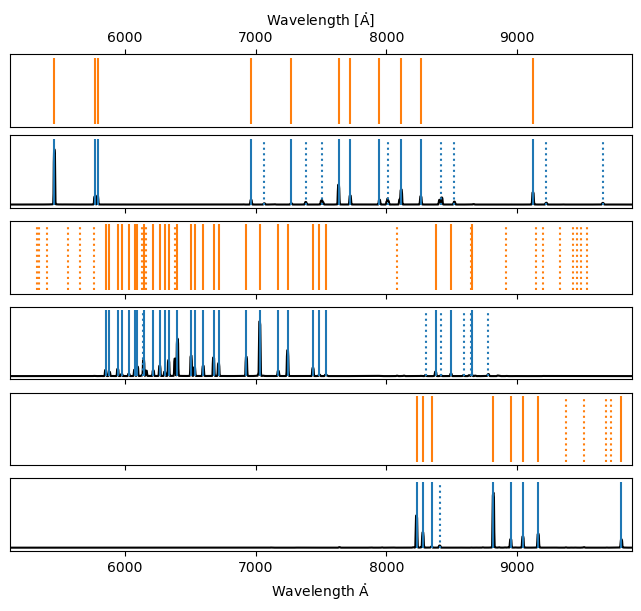

In [3]:
wc.find_lines(fwhm=4, noise_factor=15)

wc.fit_global(wavelength_bounds=[7420, 7470],
              dispersion_bounds=[2.5, 2.7],
              refine_fit=True)

wc.plot_fit(figsize=(6.3, 6), plot_values=False, obs_to_wav=True);

## 3. Evaluate the Fit

After obtaining the wavelength solution through the global optimization and refinement steps, it's important to assess the quality of the fit. In an automated data reduction pipeline, this evaluation should be done systematically by implementing quantitative quality checks based on:

- RMS of residuals between fitted and catalog wavelengths
- Number and distribution of successfully matched lines
- Behavior of residuals across the wavelength range
- Expected accuracy for the specific instrument configuration

These metrics help ensure the wavelength calibration meets the required precision for scientific analysis.

Now, let's take a quick look at the fit results. As expected, the solution matches what we got in Tutorial 2 - we just arrived at it without having to manually identify any matching lines!


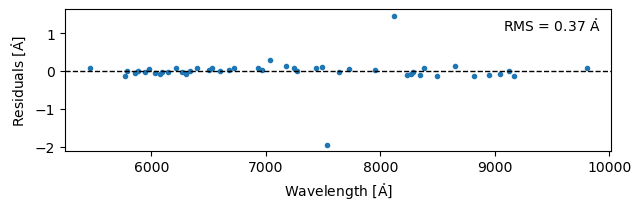

In [4]:
wc.plot_residuals(space='wavelength');

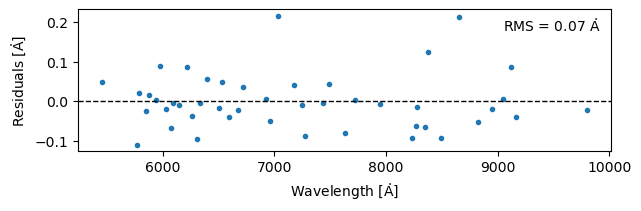

In [5]:
wc.refine_fit(max_match_distance=0.5)
wc.remove_ummatched_lines()
wc.plot_residuals(space='wavelength');

## 4. Apply the Solution

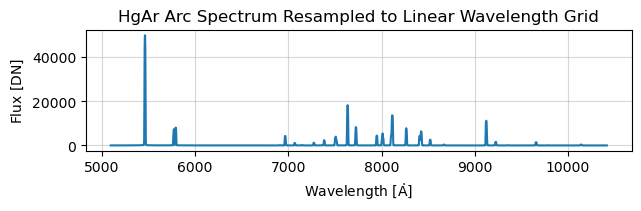

In [10]:
spectrum_wl = wc.resample(arc_spectra[0])

fig, ax = subplots(constrained_layout=True)
ax.plot(spectrum_wl.spectral_axis, spectrum_wl.flux)
ax.set_xlabel(f"Wavelength [{spectrum_wl.spectral_axis.unit.to_string('latex')}]")
ax.set_ylabel(f"Flux [{spectrum_wl.flux.unit.to_string('latex')}]")
ax.set_title("HgAr Arc Spectrum Resampled to Linear Wavelength Grid")
ax.grid(True, alpha=0.5)

As a final check, let's make sure that the wavelength grid is indeed linear, and that the flux
was conserved as it should.

In [7]:
np.diff(spectrum_wl.spectral_axis)

<SpectralAxis [2.59694553, 2.59694553, 2.59694553, ..., 2.59694553, 2.59694553,
   2.59694553] Angstrom>

In [8]:
spectrum_wl.flux.sum()

<Quantity 839275. DN>

In [9]:
arc_spectra[0].flux.sum()

<Quantity 839275. DN>

---